#BY SRINATH SAI TRIPURANENI- A20338902.

In [1]:
!pip install pyspark # installing pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark import SparkContext, SparkConf      #importing necessary packages.
import numpy as np 

In [3]:
textdata= '/content/data.txt' #loading data.

In [4]:
sc = SparkContext("local","Assignment-3: k-Means using PySpark") #initializing spark context.


In [5]:
main=sc.textFile(textdata)
main=main.map(lambda x : x.split())  # first raw data is converted to list of lists based on space by map function.

In [6]:
#main.take(1)

In [7]:
'''
from decimal import Decimal
converted=[]
def converting_to_double(x):
  for i in x:
    i=str(i).replace(',',"")
    #i=i.replace('' '')             #experimented by converting to decimal type for exact precision.
    converted.append(Decimal(i))
  return converted
'''

'\nfrom decimal import Decimal\nconverted=[]\ndef converting_to_double(x):\n  for i in x:\n    i=str(i).replace(\',\',"")\n    #i=i.replace(\'\' \'\')             #experimented by converting to decimal type for exact precision.\n    converted.append(Decimal(i))\n  return converted\n'

In [8]:
def converting_to_float(x):       #A function constructed to convert every value to float for computation.
  return float(x)

In [9]:
main=main.map(lambda x :[converting_to_float(i) for i in x]) #here first lambda takes every line as list due to map function applied above and used for loop to pass to converting_to_float function
#for converting to float.
#After experimenting with decimal finally took float due to it's advantages.
#LINK referred for advantages of float over decimal type is :- https://blog.teclado.com/decimal-vs-float-in-python/

In [10]:
#main.take(1)
main=main.zipWithIndex() # indexing every line because here every line is a datapoint and we need a certain number which will be index here, 
#to get cluster numbers or group them to certain clusters.
main=main.map(lambda x: (x[1],x[0])) #reversing index number to key and list of values to values for easy computations.

In [11]:
#main.take(1)

#Centroids initialization

In [12]:
no_of_clusters=10
no_of_iterations=20 #initializing parameters.

In [13]:
"""intial_centeroids=main.sample(False,0.00217344055640078243860030428168)
intial_centeroids.count()""" # At first sample is tried and the value 0.00217344055640078243860030428168 is 10 clusters's fraction of total 
#disadvantage of just sample is everytime we execute we get different clusters .
centroids=sc.parallelize(main.takeSample(False,no_of_clusters))
#due to disadvantage of sample choosen takesample which randomly takes exact 10 clusters.
#Link refered:-  https://stackoverflow.com/questions/32837530/how-to-get-a-sample-with-an-exact-sample-size-in-spark-rdd

In [14]:
#centeroids.take(1)
import math


#Euclidian distance calculation

In [15]:
def get_min_dist(distances):
  """min=math.inf
  for i in distances:       #A function constructed to return minimum distance from list of distances.
    min=min(i,min)"""
  return min(distances)


In [16]:
#The main logic of below function is every point is passed to this function. and we will be having 10 centroids with indices and 58 dimensions information as broadcasted variable.
#Now for every centroid we will calculate euclidian distance to the one point and stored in list. At the same time we will be maintaining a hashmap in which distance is key and respective 
#centroid index as value. After iterating each centroid broadcasted we will be having hashmap of distance between one point to one centroid as key and respective centeroid index as value.
#when we get min distance form that hashmap respective value which is centeroid index is returned.


def calculate_euclidian_distance(x): # A function constructed to get which cluster index is minimum distant to evry single point.
  cache={} #initializing hashmap of distances as key and centroid indices as valus.
  distances=[] #initializing list of distances for determining minimum distance to get grouped with that respective centeroid.
  for j in centroids.value: #Here centroids rdd is broadcasted and respectively looped .
    dist=0
    for i in range(0,58): # as our points have 58 dimensions iterating for calculating euclidian distance.
      dist+=(np.square(j[1][i]-x[1][i]))
    euclidian_distance=math.sqrt(dist) #Logic of euclidian distance.
    distances.append(euclidian_distance)
    cache[euclidian_distance]=j[0] # adding to hashmaps with each distance as key and respective centeroid index as value.
  y=get_min_dist(distances) #minimum distance is retrieved from the list from above function.
  return (cache[y],np.square(y),x[1]) # the point which is nearest to a centroid that index is returned from hashmap, another parameter is cost function and another
  #parameter is point values.


In [17]:
#centeroids=sc.broadcast(centeroids.collect())
#z=main.map(lambda x: calculate_euclidian_distance(x))

In [18]:
def make_list(x):
  return list(x)  # A Function constructed to make list of every item.

In [19]:
cost_function_per_iteration=[] # a list of cost function per iteration is initialized which will be appended in iteration loop.

# Logic of combining point to nearest cluster, taking new centeroid by averaging and repeating from step-2 for 20 iterations.

In [20]:
centroids=sc.broadcast(centroids.collect())
for i in range(no_of_iterations+1):
  clustersRDD=main.map(lambda x : calculate_euclidian_distance(x))
  """clustersRDD=clustersRDD.map(lambda x: (x[0],x[2]))  #after calculating euclidian distance taking centroid index and point information as map.
  clustersRDD=clustersRDD.reduceByKey(lambda x :make_list(x)) #experimented by reducebykey but as mapside transformations are not neccesary for this operation, just taking group bykey. 
  #Main idea is grouping centeroids indices that have same key after eculidian distance.
  #clustersRDD=clustersRDD.mapValues() # collecting all the values that are centeroids with same key grouped values.
  #clustersRDD=clustersRDD.map(lambda x:(x[0],np.average(x[1],axis =0)))""" # we need to make average along axis=0 for getting new centeroid after combining nearet point to that cluster.
  centroids=sc.broadcast(clustersRDD.map(lambda x: (x[0],x[2])).groupByKey().mapValues(make_list).map(lambda x:(x[0],np.average(x[1],axis=0))).collect())
 # Combining above logic in a line for reducing complexity of lines of code.
 #After passing every line to calculate_euclidian_distance we get nearest centeroid index and that point, so groupbykey is useful to group values for same key.
 #After grouping now we need to make average of new point and centroid for new centroid and this is done by doing np.average(x[1],axis=0) and this will be added to centroids broadcast.
 #Link referred for the reason of using groupby :-  https://www.hadoopinrealworld.com/what-is-the-difference-between-groupbykey-and-reducebykey-in-spark/#:~:text=Both%20reduceByKey%20and%20groupByKey%20result,do%20a%20map%20side%20combine.
  cost_function_per_iteration.append(clustersRDD.map(lambda x : x[1]).sum())
# as cost function also returned in the function of calculation of euclidian distance it will be appended to list.


# printing cost function for each iteration.

In [21]:
for i in range(1,len(cost_function_per_iteration)):
  print('For Iteration -' + str(i) + ' , ' ' the cost_function is :' + str(cost_function_per_iteration[i-1])) # printing for each iteration.

For Iteration -1 ,  the cost_function is :785816660.250415
For Iteration -2 ,  the cost_function is :699938263.6472006
For Iteration -3 ,  the cost_function is :637132503.4745126
For Iteration -4 ,  the cost_function is :554822399.3469319
For Iteration -5 ,  the cost_function is :530085713.7237017
For Iteration -6 ,  the cost_function is :513727063.2023392
For Iteration -7 ,  the cost_function is :499988180.6649357
For Iteration -8 ,  the cost_function is :487627529.65387887
For Iteration -9 ,  the cost_function is :480000451.15133333
For Iteration -10 ,  the cost_function is :474444113.9702053
For Iteration -11 ,  the cost_function is :470391140.9089557
For Iteration -12 ,  the cost_function is :467621152.9173128
For Iteration -13 ,  the cost_function is :466135178.0535664
For Iteration -14 ,  the cost_function is :464923947.5146854
For Iteration -15 ,  the cost_function is :464063473.94921577
For Iteration -16 ,  the cost_function is :463308142.2841933
For Iteration -17 ,  the cost_f

#Plotting a graph

In [22]:
x=np.arange(1,22,1) #taking x-axis values.

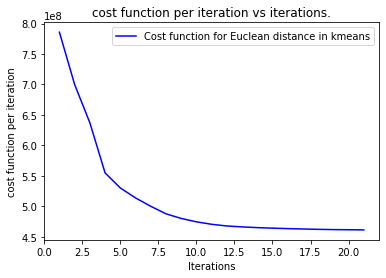

In [23]:
fig, ax = plt.subplots()
ax.plot(x, cost_function_per_iteration, color='blue',label="Cost function for Euclean distance in kmeans")
ax.legend(loc=0)
plt.xlabel('Iterations')
plt.ylabel('cost function per iteration')                      #plotting k-means graph.
plt.title('cost function per iteration vs iterations.')
plt.show()

#Calculation of percentage change

In [24]:
#here as cost_function_per_iteration is stored in list first iteration would be that list[0] th element and 10th iterated value will be that list[9]th value.
percetange_change=((cost_function_per_iteration[0]-cost_function_per_iteration[9])/(cost_function_per_iteration[0]))*100
print(" The percentage change in cost function from 1st iteration to 10th iteration using Euclidiean distance in kmeans is :" + str(percetange_change) + ' % ') 
#calculating percentage change from the list created as first element of list will be first iterated cost function. and last element will be last iterated cost function value.

 The percentage change in cost function from 1st iteration to 10th iteration using Euclidiean distance in kmeans is :39.62407035007187 % 


#Writing centroids to file.

In [25]:
output_cache=[]
m=1
for i in centroids.value:                                         #appending centroids points in list.
  output_cache.append('Centroid ' + str(m) + ':-' + str(i[1]))
  m+=1

In [26]:
rdd=sc.parallelize(output_cache) #converting list to rdd
rdd.coalesce(1).saveAsTextFile("centroids of kmeans(1).txt") # saving to file from rdd.

#DELETING ALL RDDS FROM MEMORY FOR MEMORY EFFICIENCY.

In [27]:
rdd.unpersist()
clustersRDD.unpersist()
main.unpersist()                               #unpersisting as there willbe no uses after centroids file.
centroids.unpersist()
